In [1]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
from ler.utils import FunctionConditioning
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

Setting multiprocessing start method to 'fork'


In [2]:
def SFR_Madau(z, a=0.015, b=2.7, c=2.9, d=5.6):
    """
    https://arxiv.org/pdf/1606.07887.pdf
    """

    SFR =  a * (1+z)**b / (1 + ((1+z)/c)**d) #[MPc-3]
    return SFR # [Msun yr-1 Gpc-3] in comoving volume

In [3]:
td_min=20e-3 # Gyr
td_max=10 # Gyr
z_arr = np.linspace(0.01, 10, 5)
td_arr = np.linspace(td_min, td_max, 5)
# # make a meshgrid
# Z, TD = np.meshgrid(z_arr, td_arr)

H0=cosmo.H0.value
Omega_M=cosmo.Om0
Omega_Lambda=cosmo.Ode0

def E(z_prime):
    """Hubble parameter as a function of redshift."""
    return np.sqrt(Omega_M * (1 + z_prime)**3 + Omega_Lambda)

def integrand(z_prime):
    """Integrand for the equation."""
    return 1 / (H0* (1 + z_prime) * E(z_prime)) * 977.813 

def time_delay(zform, z):
    """Time delay between formation and observation."""
    integral, _ = quad(integrand, z, zform)
    return integral

def equation_to_solve(zform, z, td):
    """Equation to solve for zform."""

    return td - time_delay(zform, z)

# Solve the equation numerically for z=0.5 and td=0.5 Gyr
# def find_zform(z, td, zform_max, n_points=200, tol=1e-4):
#     """Find zform using grid search and linear interpolation."""
#     zform_min = z
#     zform_trial = np.geomspace(zform_min, zform_max, n_points)
#     residuals = np.array([equation_to_solve(zf, z, td) for zf in zform_trial])
    
#     # Find where the sign of the residual changes
#     sign_change = np.where(np.sign(residuals[:-1]) != np.sign(residuals[1:]))[0]

#     if len(sign_change) == 0:
#         print("No solution found in the given range.")
#         return None

#     idx = sign_change[0]
    
#     # # Linear interpolation for better precision
#     #zform_solution = np.interp(0, residuals[idx:idx+2], zform_trial[idx:idx+2])
#     # use spline interpolation instead, interp1d
#     if idx-2 < 0:
#         idx_low = 0
#         idx_high = 4
#     elif idx+2 > len(residuals):
#         idx_low = len(residuals)-4
#         idx_high = len(residuals)
#     else:
#         idx_low = idx-2
#         idx_high = idx+2

#     zform_solution = interp1d(residuals[idx_low:idx_high], zform_trial[idx_low:idx_high], kind='cubic')(0)

#     if np.abs(equation_to_solve(zform_solution, z, td)) > tol:
#         print(f"Warning: Solution may not meet tolerance at z={z}, td={td}.")
    
#     return zform_solution

# use fsolve instead
def find_zform(z, td, zform_max, tol=1e-4):
    """Find zform using grid search and linear interpolation."""
    zform_solution = fsolve(equation_to_solve, z, args=(z, td))

    # if np.abs(equation_to_solve(zform_solution, z, td)) > tol:
    #     print(f"Warning: Solution may not meet tolerance at z={z}, td={td}.")
    
    return zform_solution

In [17]:
find_zform(z=1, td=2, zform_max=1, tol=1e-4)

array([1.70427772])

In [18]:
# z=1.0, td=0.6531019968273368.

In [19]:
# def function(x, z, zform_max=11.):
#     dt_arr = []
#     for x_ in x:
#         # fit [0,1] to [z, zform_max]
#         zform = x_*(zform_max-z) + z 
#         dt_arr.append(time_delay(zform, z))
#     return np.array(dt_arr)# , zform, z
# size = 100
# time_delay_obj = FunctionConditioning(
#     function=function,
#     x_array=np.linspace(0.0, 1, size),
#     conditioned_y_array=np.linspace(0.01, 10, size),
#     param_dict_given={size: size, 'zform_max': 11.},
#     directory='./interpolator_pickle',
#     sub_directory='zform',
#     name='zform',
#     create_new=True,
#     create_function=True,
#     create_function_inverse=False,
#     create_pdf=False,
#     create_rvs=False,
#     multiprocessing_function=False,
#     callback='function',
# )

# def function_td(zform, z, zform_max=11.):

#     x = (zform - z) / (zform_max - z)
#     return time_delay_obj(x, z)
    

In [20]:
time_delay(1000, 2)

3.2261587744299334

In [4]:
# montecalo integration
def integrand_rates(z, size=100000, zform_max=1000.):

    td = np.random.uniform(td_min, td_max, size)
    td_max_allowed = time_delay(zform_max, z)
    # idx = td < td_max_allowed
    idx = np.where(td < td_max_allowed)[0]
    P_td = np.zeros_like(td)
    # print('idx', idx)
    # print('td', td)
    # print('td_max_allowed', td_max_allowed)
    P_td[idx] = 1/(np.log(td_max/td_min) * td[idx]) 

    zform = np.zeros_like(td)
    for idx_ in idx:
        zform[idx_] = find_zform(z, td[idx_], zform_max)

    psi = SFR_Madau(zform)

    integral = 1/(td_max - td_min) * np.sum(P_td * psi)
    return integral

In [ ]:
# integrand_rates(z=2.0)
# 5.8s

71.6707330660469

In [ ]:
# integrand_rates(z=2.)

69.86935968197331

In [6]:
def integrand_rates_mp(input_args):
    z = input_args[0]
    idx = input_args[1]

    result = integrand_rates(z)
    return int(idx), result

In [7]:
# setup multiprocessing with tqdm and imap
from multiprocessing import Pool
from tqdm import tqdm

size = 48
zs = np.geomspace(0.001, 10, size)
idx_tracker = np.arange(size)
#  concatenate the input arguments
input_args = np.vstack([zs, idx_tracker]).T
n_processes = 8
rm_result = np.zeros(size)

with Pool(n_processes) as p:
    for result in tqdm(p.imap_unordered(integrand_rates_mp, input_args), total=len(input_args)):
        idx, res = result
        rm_result[idx] = res
# time: 2:29s

100%|██████████| 48/48 [02:16<00:00,  2.84s/it]


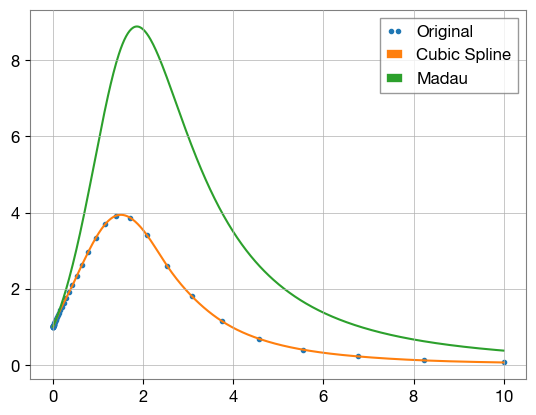

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

spline = CubicSpline(zs, rm_result, extrapolate=True)

plt.plot(zs, rm_result/spline(0), '.', label='Original')
plt.plot(np.linspace(0, 10, 500), spline(np.linspace(0, 10, 500))/spline(0), label='Cubic Spline')
plt.plot(np.linspace(0, 10, 500), SFR_Madau(np.linspace(0, 10, 500))/SFR_Madau(0), label='Madau')
plt.legend()
# plt.yscale('log')
# plt.xscale('log')
plt.show()


In [9]:
rm_result/spline(0)

array([1.0029945 , 1.00362259, 1.00438674, 1.00531645,
       1.00644763, 1.00782396, 1.00949865, 1.01153645,
       1.00240992, 1.00539605, 1.00903013, 1.01345293,
       1.01883579, 1.02538714, 1.03336026, 1.04306247,
       1.05841698, 1.07283625, 1.09035966, 1.11162909,
       1.1373949 , 1.16851509, 1.20594024, 1.25068092,
       1.3085267 , 1.37111306, 1.44421094, 1.52948237,
       1.62985636, 1.75058453, 1.90010572, 2.0870216 ,
       2.33573104, 2.6218286 , 2.96031682, 3.3343522 ,
       3.69149889, 3.92099769, 3.86227814, 3.40811745,
       2.59314381, 1.79588097, 1.14260538, 0.686002  ,
       0.3954134 , 0.22083291, 0.11548455, 0.06064368])

In [27]:
rm_result[0]

16.5298516587365

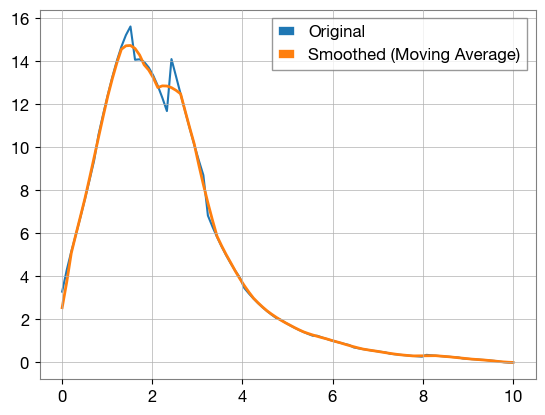

In [153]:
import numpy as np
import matplotlib.pyplot as plt

# # Example data (replace with your rm and z arrays)
# z = np.linspace(0, 10, 100)
# rm = np.sin(z) + 0.1 * np.random.randn(100)

# Moving average function
def moving_average(y, window_size):
    return np.convolve(y, np.ones(window_size)/window_size, mode='same')

smoothed_rm = moving_average(rm_result, window_size=5)

plt.plot(zs, rm_result, label='Original')
plt.plot(zs, smoothed_rm, label='Smoothed (Moving Average)', linewidth=2)
plt.legend()
plt.show()



In [142]:
# cubic spline interpolation
from scipy.interpolate import CubicSpline
rm_spline = CubicSpline(zs, smoothed_rm, extrapolate=True)

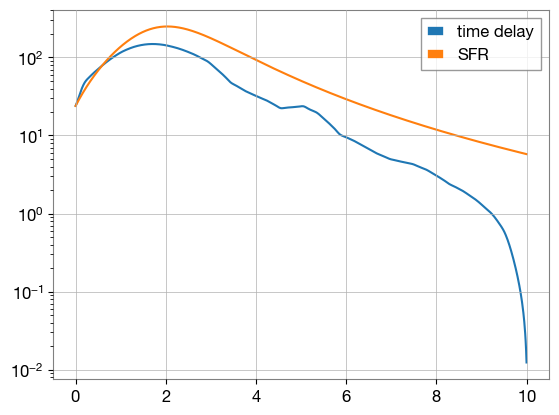

In [146]:
zs = np.linspace(0.001, 10, 1000)
plt.plot(zs, rm_spline(zs)/rm_spline(0)*23.9, label='time delay')
plt.plot(zs, SFR_Madau(zs)/SFR_Madau(0)*23.9, label='SFR')
plt.legend()
plt.yscale('log')
plt.show()

In [29]:
# load json 
from ler.utils import get_param_from_json, append_json

param_dict = get_param_from_json('/Users/phurailatpamhemantakumar/phd/mypackages/ler/devdir/rm_rate.json')
param_dict, param_dict['rm'].shape, param_dict['zs'].shape

({'zs': array([1.00000000e-03, 1.10090090e-02, 2.10180180e-02, ...,
         9.97998198e+00, 9.98999099e+00, 1.00000000e+01]),
  'rm': array([ 1.66502450e-04,  1.70157562e-04,  1.77047902e-04, ...,
         -9.49519412e-08, -5.26762154e-08, -1.58818678e-22])},
 (1000,),
 (1000,))

In [31]:
from scipy.interpolate import CubicSpline
zs = np.linspace(0.001, 10, 1000)
rm_spline = CubicSpline(zs, param_dict['rm'], extrapolate=True)

Setting multiprocessing start method to 'fork'


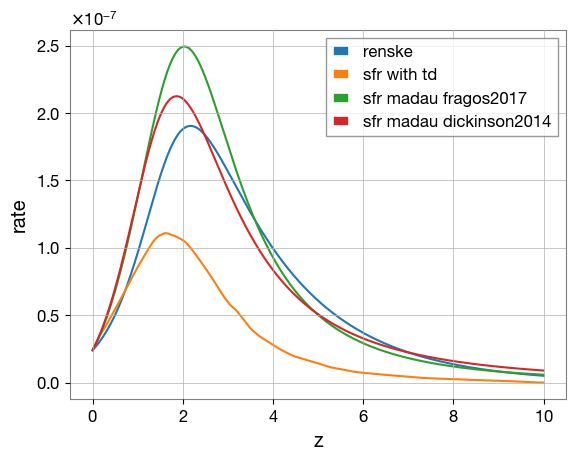

In [1]:
from ler.gw_source_population import merger_rate_density_bbh_popI_II_oguri2018, sfr_with_time_delay, sfr_madau_fragos2017, sfr_madau_dickinson2014
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

zs = np.linspace(0.001, 10, 1000)
plt.plot(zs, merger_rate_density_bbh_popI_II_oguri2018(zs)/merger_rate_density_bbh_popI_II_oguri2018(0)*23.9 * 1e-9, label='renske')
plt.plot(zs, sfr_with_time_delay(zs)/sfr_with_time_delay(0)*23.9 * 1e-9, label='sfr with td')
plt.plot(zs, sfr_madau_fragos2017(zs)/sfr_madau_fragos2017(0)*23.9 * 1e-9, label='sfr madau fragos2017')
plt.plot(zs, sfr_madau_dickinson2014(zs)/sfr_madau_dickinson2014(0)*23.9 * 1e-9, label='sfr madau dickinson2014')
plt.legend()
plt.xlabel('z')
plt.ylabel('rate')
plt.show()

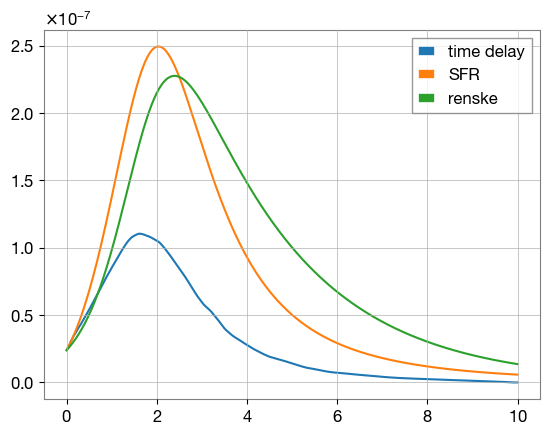

In [35]:
# plot
zs = param_dict['zs']
rm_rate = param_dict['rm']
plt.plot(zs, rm_spline(zs)/rm_spline(0)*23.9 * 1e-9, label='time delay')
plt.plot(zs, SFR_Madau(zs)/SFR_Madau(0)*23.9 * 1e-9, label='SFR')
plt.plot(zs, merger_rate_density_bbh_popI_II_oguri2018(zs), label='renske')
plt.legend()
#plt.yscale('log')
plt.show()

In [20]:
zs = np.linspace(0.001, 10, 200)
z_value = rm_spline(zs)

In [22]:
# spline
from scipy.interpolate import CubicSpline
rm_spline = CubicSpline(zs, z_value, extrapolate=True).c

In [25]:
# save to json
import json
with open('rm_rate_spline.json', 'w') as f:
    json.dump({'rm': z_value.tolist(), 'rm_spline': rm_spline.tolist()}, f)

In [3]:
from ler.gw_source_population import sfr_madau_fragos2017_with_bbh_td, sfr_madau_dickinson2014_with_bbh_td, sfr_madau_fragos2017_with_bns_td, sfr_madau_dickinson2014_with_bns_td, sfr_madau_dickinson2014, merger_rate_density_bbh_popI_II_oguri2018
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

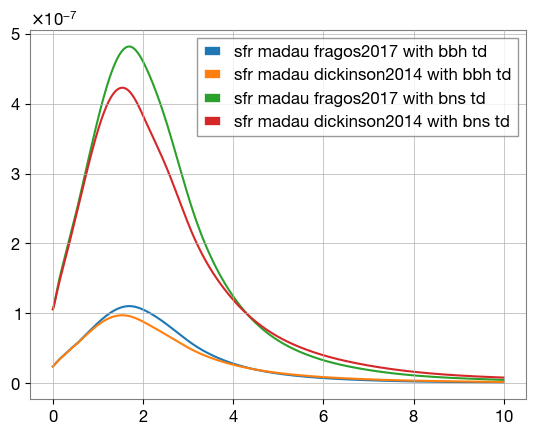

In [4]:
# plt
zs = np.linspace(0.001, 10, 1000)
plt.plot(zs, sfr_madau_fragos2017_with_bbh_td(zs), label='sfr madau fragos2017 with bbh td')
plt.plot(zs, sfr_madau_dickinson2014_with_bbh_td(zs), label='sfr madau dickinson2014 with bbh td')
plt.plot(zs, sfr_madau_fragos2017_with_bns_td(zs), label='sfr madau fragos2017 with bns td')
plt.plot(zs, sfr_madau_dickinson2014_with_bns_td(zs), label='sfr madau dickinson2014 with bns td')

plt.legend()
plt.show()

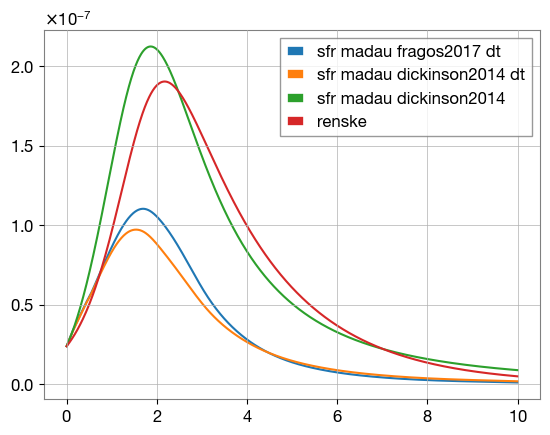

In [8]:
# plt
zs = np.linspace(0.001, 10, 1000)
plt.plot(zs, sfr_madau_fragos2017_with_dt(zs), label='sfr madau fragos2017 dt')
plt.plot(zs, sfr_madau_dickinson2014_with_dt(zs), label='sfr madau dickinson2014 dt')
plt.plot(zs, sfr_madau_dickinson2014(zs)/sfr_madau_dickinson2014(0)*sfr_madau_dickinson2014_with_dt(0), label='sfr madau dickinson2014')
plt.plot(zs, merger_rate_density_bbh_popI_II_oguri2018(zs), label='renske')
plt.legend()
plt.show()

In [1]:
from ler.gw_source_population import sfr_with_time_delay

input_args = [
    2.0, # zs
    0, # idx
    10e-3, # td_min
    10, # td_max
    70.0, # H0
    0.3, # Omega_M
    0.7, # Omega_Lambda
    0.01, # a
    2.6, # b
    3.2, # c
    6.2 # d
]

Setting multiprocessing start method to 'fork'


In [2]:
sfr_with_time_delay(input_args)

(0, 74.43193499177617)

In [3]:
sfr_with_time_delay?

Type:        module
String form: <module 'ler.gw_source_population.sfr_with_time_delay' from '/Users/phurailatpamhemantakumar/phd/mypackages/ler/ler/gw_source_population/sfr_with_time_delay.py'>
File:        ~/phd/mypackages/ler/ler/gw_source_population/sfr_with_time_delay.py
Docstring:   <no docstring>

In [1]:
from ler.gw_source_population import CBCSourceRedshiftDistribution
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Setting multiprocessing start method to 'fork'


In [2]:
a=0.015, b=2.7, c=2.9, d=5.6

SyntaxError: invalid syntax. Maybe you meant '==' or ':=' instead of '='? (2493401579.py, line 1)

In [3]:
from ler.gw_source_population import CBCSourceRedshiftDistribution

cbc = CBCSourceRedshiftDistribution(
    npool=8,
    event_type='BNS',
    merger_rate_density='merger_rate_density_Borhanian_Sathyaprakash2024',
    merger_rate_density_param=dict(
        R0=105.5 * 1e-9, a=0.015, b=2.7, c=2.9, d=5.6, td_min=20e-3, td_max=10.0
    ),
    create_new_interpolator = dict(
            merger_rate_density=dict(create_new=False, resolution=48)
    ),
)


Initializing CBCSourceRedshiftDistribution...

luminosity_distance interpolator will be loaded from ./interpolator_pickle/luminosity_distance/luminosity_distance_0.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_3.pickle
using ler available merger rate density model: merger_rate_density_Borhanian_Sathyaprakash2024
{'z_min': 0.001, 'z_max': 10.0, 'cosmology': LambdaCDM(name=None, H0=<Quantity 70. km / (Mpc s)>, Om0=0.3, Ode0=0.7, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=None), 'event_type': 'BNS', 'name': 'merger_rate_density_Borhanian_Sathyaprakash2024', 'resolution': 48, 'R0': 1.0550000000000001e-07, 'a': 0.015, 'b': 2.7, 'c': 2.9, 'd': 5.6, 'td_min': 0.02, 'td_max': 10.0}
Numerically solving the merger_rate_density with time delay
merger_rate_density_Borhanian_Sathyaprakash2024 interpolator will be loaded from ./interpolator_pickle/merger_rate_density/merger_rate_density_Borh

In [6]:
cbc.merger_rate_density_param

{'R0': 1.0550000000000001e-07,
 'a': 0.015,
 'b': 2.7,
 'c': 2.9,
 'd': 5.6,
 'td_min': 0.02,
 'td_max': 10.0}

In [4]:
from ler.gw_source_population import merger_rate_density_bbh_popI_II_oguri2018, sfr_madau_fragos2017_with_bns_td, sfr_madau_dickinson2014_with_bns_td

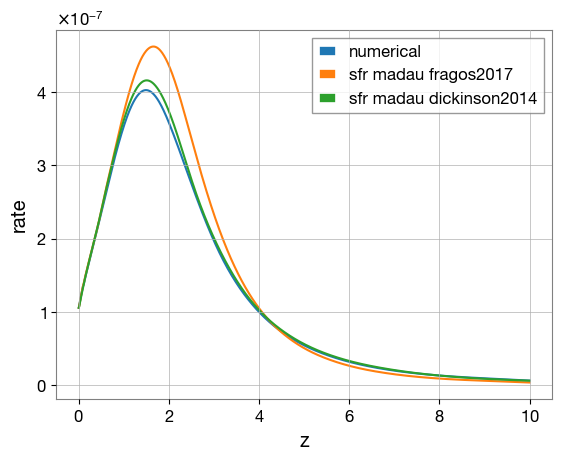

In [5]:
# plot merger rate density
zs = np.linspace(0.001, 10, 1000)
plt.plot(zs, cbc.merger_rate_density(zs), label='numerical')
# plt.plot(zs, merger_rate_density_bbh_popI_II_oguri2018(zs), label='renske')
plt.plot(zs, sfr_madau_fragos2017_with_bns_td(zs, R0=105.5 * 1e-9), label='sfr madau fragos2017')
plt.plot(zs, sfr_madau_dickinson2014_with_bns_td(zs, R0=105.5 * 1e-9), label='sfr madau dickinson2014')
plt.xlabel('z')
plt.ylabel('rate')
plt.legend()
plt.show()

In [3]:
merger_rate_density_ = 'merger_rate_density_Borhanian_Sathyaprakash2024'
event_type = 'BNS'
list_ = ['merger_rate_density_Borhanian_Sathyaprakash2024',
                  #'sfr_madau_fragos2017_with_bbh_dt', 
                  # 'sfr_madau_dickinson2014_with_bbh_dt',
                  # 'sfr_madau_fragos2017_with_bns_dt', 
                  # 'sfr_madau_dickinson2014_with_bns_dt'
                ]
if merger_rate_density_ in list_:
    if event_type == "BBH":
        merger_rate_density_param_ = dict(R0=23.9 * 1e-9, a=0.01, b=2.6, c=3.2, d=6.2, td_min=10e-3, td_max=10.0)
    elif event_type == "BNS":
        merger_rate_density_param_ = dict(R0=105.5 * 1e-9, a=0.01, b=2.6, c=3.2, d=6.2, td_min=20e-3, td_max=10.0)
    else:
        raise ValueError("event_type must be 'BBH', 'BNS'")

In [4]:
merger_rate_density_param_

{'R0': 1.0550000000000001e-07,
 'a': 0.01,
 'b': 2.6,
 'c': 3.2,
 'd': 6.2,
 'td_min': 0.02,
 'td_max': 10.0}

In [3]:
from ler.lens_galaxy_population import OpticalDepth

od = OpticalDepth(
    lens_param_samplers = dict(axis_ratio='axis_ratio_padilla_strauss'),
    lens_param_samplers_params = dict(axis_ratio=dict(q_min=0.2, q_max=1.0)),
)


Initializing OpticalDepth class

comoving_distance interpolator will be loaded from ./interpolator_pickle/comoving_distance/comoving_distance_2.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_2.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_3.pickle

interpolated_cross_section_function

Interpolated cross section function loaded from ./interpolator_pickle/cross_section_function/cross_section_function_1.pickle
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion/velocity_dispersion_ewoud_3.pickle
using ler available axis_ratio function : axis_ratio_padilla_strauss
axis_ratio_padilla_strauss interpolator will be loaded from ./interpolator_pickle/axis_ratio/axis_ratio_padill

In [2]:
od.axis_ratio.info

{'name': 'axis_ratio_padilla_strauss',
 'resolution': 500,
 'q_min': 0.5,
 'q_max': 1.0,
 'sigma': None}

In [9]:
od.lens_param_samplers_params['axis_ratio'] 

{'q_min': 0.2, 'q_max': 1.0}

In [1]:
from ler.lens_galaxy_population import OpticalDepth

ler = OpticalDepth(npool=8)

Setting multiprocessing start method to 'fork'

Initializing OpticalDepth class

using lens_redshift_epl_shear2_mp
comoving_distance interpolator will be loaded from ./interpolator_pickle/comoving_distance/comoving_distance_2.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_2.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_3.pickle
Interpolated cross section function loaded from ./interpolator_pickle/cross_section_function/cross_section_function_1.pickle
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion/velocity_dispersion_ewoud_3.pickle
using ler available axis_ratio function : axis_ratio_rayleigh
axis_ratio_rayleigh interpolator will be loaded from ./interpolator_pickle

In [2]:
ler.lens_param_samplers['density_profile_slope_sl']

'density_profile_slope_normal'

In [4]:
ler.density_profile_slope.info

{'name': 'density_profile_slope_normal', 'mean': 1.99, 'std': 0.149}

In [1]:
from ler.lens_galaxy_population import LensGalaxyParameterDistribution, phi_cut_SIE
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

ler = LensGalaxyParameterDistribution(
    npool=8,
    lens_param_samplers=dict(velocity_dispersion='velocity_dispersion_ewoud'),
    lens_param_samplers_params=dict(velocity_dispersion=dict(
                    sigma_min=100., sigma_max=400., alpha=0.94, beta=1.85, phistar=2.099e-2*(cosmo.h/0.7)**3, sigmastar=113.78
                )),
)

Setting multiprocessing start method to 'fork'

Initializing LensGalaxyParameterDistribution class...


Initializing OpticalDepth class

using lens_redshift_epl_shear2_mp
comoving_distance interpolator will be loaded from ./interpolator_pickle/comoving_distance/comoving_distance_2.pickle
angular_diameter_distance interpolator will be loaded from ./interpolator_pickle/angular_diameter_distance/angular_diameter_distance_2.pickle
differential_comoving_volume interpolator will be loaded from ./interpolator_pickle/differential_comoving_volume/differential_comoving_volume_3.pickle
Interpolated cross section function loaded from ./interpolator_pickle/cross_section_function/cross_section_function_9.pickle
using ler available velocity dispersion function : velocity_dispersion_ewoud
velocity_dispersion_ewoud interpolator will be loaded from ./interpolator_pickle/velocity_dispersion/velocity_dispersion_ewoud_14.pickle
using ler available axis_ratio function : axis_ratio_rayleigh
axis_ratio_raylei

In [2]:
ler.buffer_size = 500
ler.rejection_sample_sl = ler.rjs_with_cross_section_mp
lensed_param_epl100 = ler.sample_all_routine_epl_shear_sl(5000)
# 50, 100: 51s
# 10, 100: much longer
# 100, 100: 31s
# 200, 100: 18s
# 500, 100: 12s
# 1000, 100: 13s

100%|███████████████████████████████████████████████████████████| 5000/5000 [10:30<00:00,  7.93it/s]


In [2]:
ler.buffer_size = 100
ler.rejection_sample_sl = ler.rjs_with_cross_section_sie_feixu
lensed_param_sie = ler.sample_lens_parameters(100)
# ler.buffer_size = 1000, size: 10000, time: 10.8s
# ler.buffer_size = 1000, size: 50000, time: 53s
# sigma_min=50, ler.buffer_size = 1000, size: 50000, time: 53s
# mp: ler.buffer_size = 1000, size: 10000, time: 1m 47.9s
# ler.buffer_size = 10000, size: 10000, time: 1m 47.9s
# ler.buffer_size = 2000, size: 50000, time: 1m 47.0s
# sigma_min=50, ler.buffer_size = 2000, size: 50000, time: 1m 51.1s

sampling lens parameters with sample_all_routine_sie_sl...


  0%|                                                                       | 0/100 [00:00<?, ?it/s]

4.750816723527229e-12


100%|████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 216.11it/s]


2.7372773597038244e-11
3.875574050626978e-11
5.47674476277151e-12
3.740618583553784e-12
2.0205197737342543e-11
9.139196013696473e-11
6.28233368914085e-11
8.461926455981144e-12
1.1619455377909946e-11
9.657209216817603e-13
4.0118286785015475e-12
4.895635020685009e-12
8.753342693236515e-12
5.056618863745255e-12
5.0805498882142985e-12
7.274520331714416e-12
1.301588412421858e-10
2.203264056387877e-11
1.0663678089906602e-10
1.3430418523546644e-11
3.172262322019968e-11
8.830666745472822e-12
8.284011842544495e-13
9.035385668436986e-12
9.710511212143353e-12
2.937759319811194e-12
4.511886468750698e-12
3.701744366511548e-11
4.267607867670822e-12
1.503573993847644e-11
8.398528555050548e-12
7.491996936269148e-12
1.3502716507400716e-10
7.056483331432495e-11
1.0609464308598206e-10
5.958040815697579e-12
2.4815760486843246e-10
5.138587912201687e-12
3.0656042465971512e-12
2.1715662419495187e-11
2.7028316815694696e-11
5.919033314006622e-12
4.949404885717928e-12
1.4433837641342437e-12
2.3740257323793474e-

In [24]:
ler.buffer_size = 1000
ler.rejection_sample_sl = ler.rjs_with_cross_section_mp
lensed_param_epl = ler.sample_all_routine_epl_shear_sl(5000)
# size=1000, buffer_size=1000, time: 1m 34s
# size=1000, buffer_size=2000, time: 1m 34s

  3%|█▋                                                          | 139/5000 [00:18<10:43,  7.55it/s]


KeyboardInterrupt: 

In [14]:
sigma = lensed_param_epl['sigma']
zl = lensed_param_epl['zl']
zs = lensed_param_epl['zs']
q = lensed_param_epl['q']
e1 = lensed_param_epl['e1']
e2 = lensed_param_epl['e2']
gamma = lensed_param_epl['gamma']
gamma1 = lensed_param_epl['gamma1']
gamma2 = lensed_param_epl['gamma2']

theta_E = ler.compute_einstein_radii(sigma, zl, zs)
cross_section_sie = theta_E*phi_cut_SIE(q)
cross_section_epl = ler.cross_section(theta_E, e1, e2, gamma, gamma1, gamma2)


In [15]:
np.max(cross_section_epl/cross_section_sie), np.max(cross_section_epl/cross_section_sie)

(0.00014417417378016607, 0.00014417417378016607)

In [16]:
np.max(cross_section_epl/theta_E), np.max(cross_section_epl/theta_E)

(0.00014408220099257, 0.00014408220099257)

In [17]:
np.max(cross_section_sie/theta_E), np.max(cross_section_sie/theta_E)

(0.9999801298284668, 0.9999801298284668)

In [24]:
phi_cut_SIE(np.array([0.5,1.]))

array([0.92419624, 1.        ])

In [43]:
# save as pickle
from ler.utils import save_pickle, load_pickle
# save_pickle('lensed_param_epl.pkl', lensed_param_epl)
lensed_param_epl = load_pickle('lensed_param_epl.pkl')

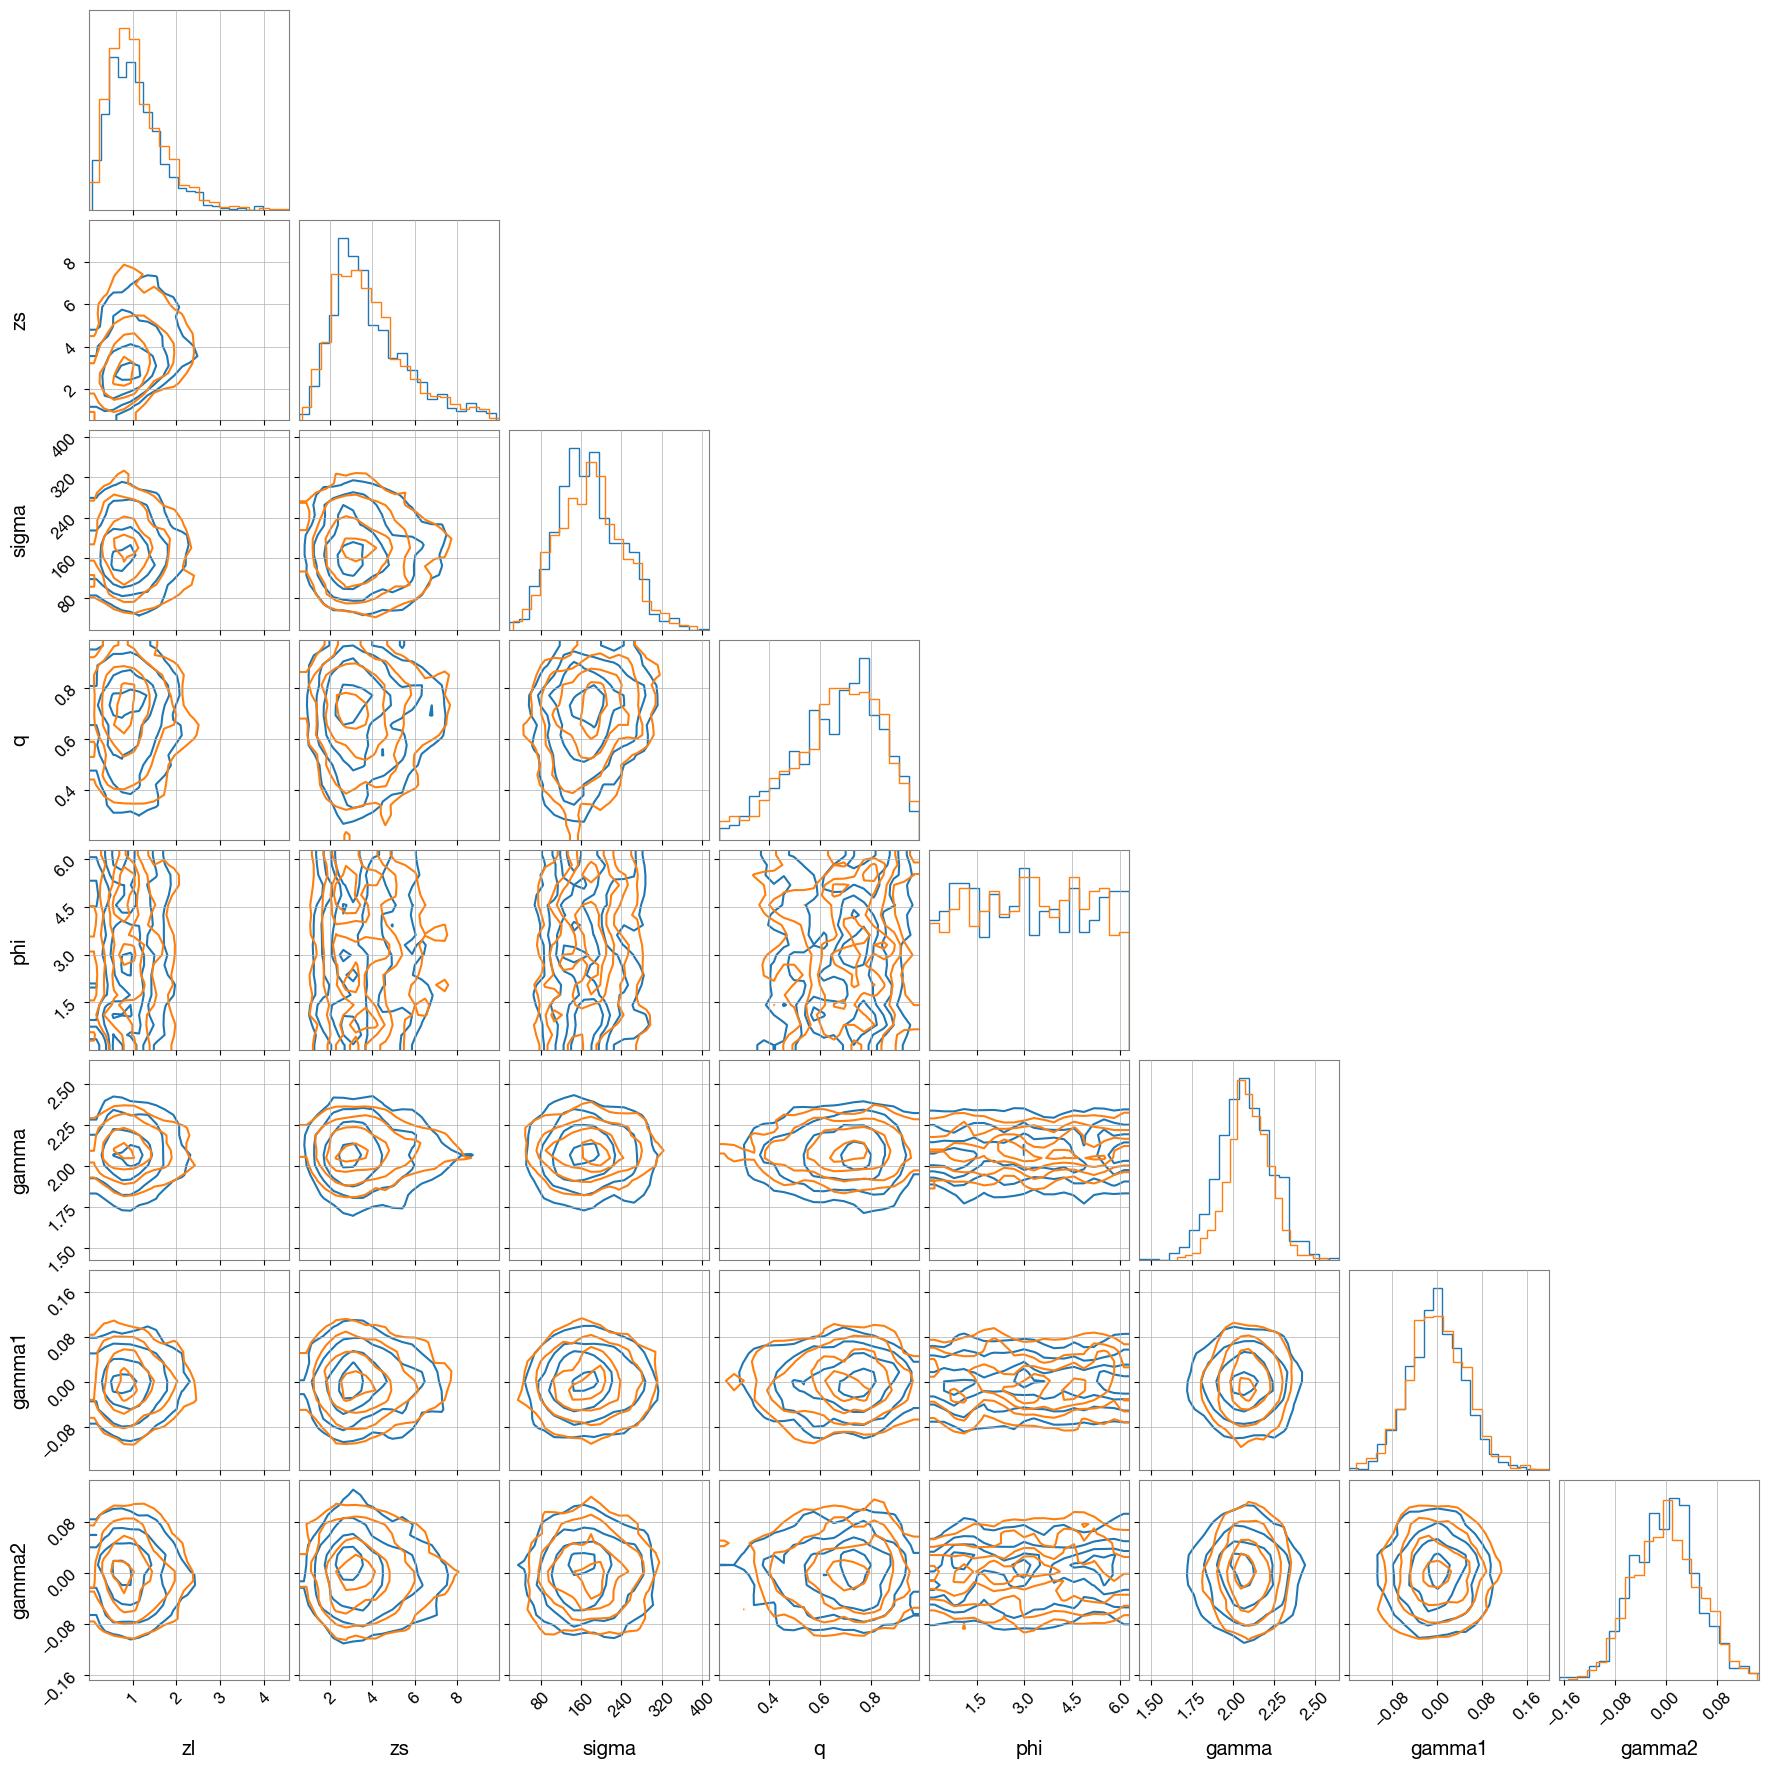

In [44]:
from corner import corner
import numpy as np
import matplotlib.pyplot as plt

name_list = ['zl', 'zs', 'sigma', 'q', 'phi', 'gamma', 'gamma1', 'gamma2']
size = 1000

sie_list = np.vstack([lensed_param_sie[name][:size] for name in name_list]).T
# sie_list2 = np.vstack([lensed_param_sie2[name][:size] for name in name_list]).T
epl_list = np.vstack([lensed_param_epl[name][:size] for name in name_list]).T

# overlapping corner plot
# avoid scatter points
fig = corner(sie_list, labels=name_list, color='C0', plot_density=False, plot_datapoints=False, smooth=0.8)
# fig = corner(sie_list2, labels=name_list, color='C2', fig=fig, plot_density=False, plot_datapoints=False, smooth=0.8)
corner(epl_list, labels=name_list, color='C1', fig=fig, plot_density=False, plot_datapoints=False, smooth=0.8)
plt.show()

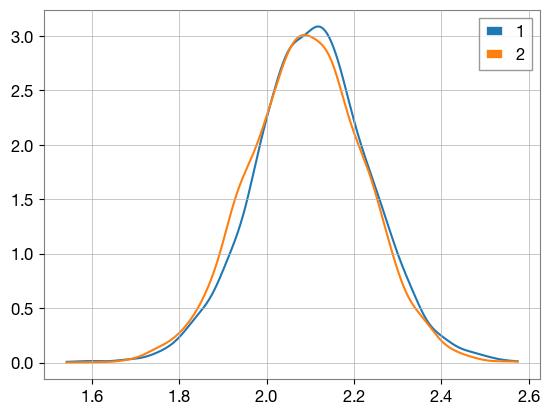

In [9]:
# scipy kde
from scipy.stats import gaussian_kde
import numpy as np
import matplotlib.pyplot as plt

gamma = lensed_param_epl100['gamma']

kde = gaussian_kde(gamma)
x = np.linspace(np.min(gamma), max(gamma), 5000)
y = kde(x)

gamma_sim = np.random.normal(2.091, 0.133, 5000)
kde2 = gaussian_kde(gamma_sim)
y2 = kde2(x)


plt.plot(x, y, label='1')
plt.plot(x, y2, label='2')
plt.legend()
plt.show()

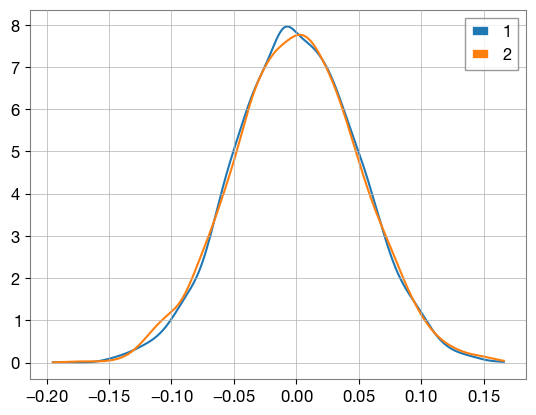

In [8]:
gamma1 = lensed_param_epl100['gamma1']
kde = gaussian_kde(gamma1)
x = np.linspace(np.min(gamma1), max(gamma1), 5000)
y = kde(x)

gamma_sim = np.random.normal(0.0, 0.05, 5000)
kde2 = gaussian_kde(gamma_sim)
y2 = kde2(x)


plt.plot(x, y, label='1')
plt.plot(x, y2, label='2')
plt.legend()
plt.show()

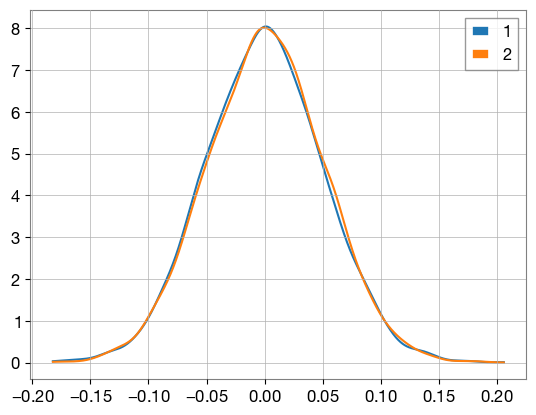

In [10]:
gamma2 = lensed_param_epl100['gamma2']
kde = gaussian_kde(gamma2)
x = np.linspace(np.min(gamma2), max(gamma2), 5000)
y = kde(x)

gamma_sim = np.random.normal(0.0, 0.05, 5000)
kde2 = gaussian_kde(gamma_sim)
y2 = kde2(x)


plt.plot(x, y, label='1')
plt.plot(x, y2, label='2')
plt.legend()
plt.show()

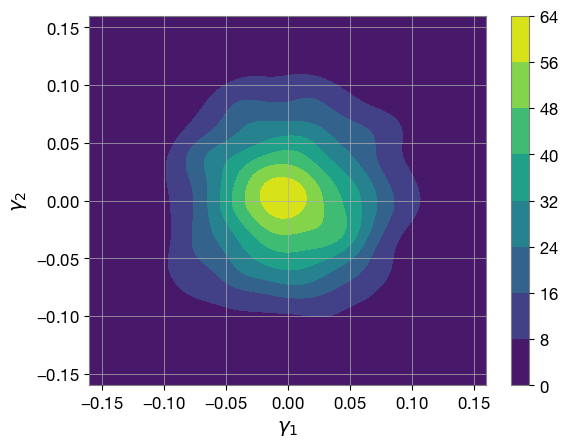

In [46]:
# gamma1, gamma2, 2D KDE

gamma1 = lensed_param_epl['gamma1']
gamma2 = lensed_param_epl['gamma2']

kde = gaussian_kde([gamma1, gamma2])
x, y = np.mgrid[-0.16:0.16:100j, -0.16:0.16:100j]
pos = np.vstack([x.ravel(), y.ravel()])
z = kde(pos).reshape(x.shape)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.contourf(x, y, z, cmap='viridis')
ax.set_xlabel(r'$\gamma_1$')
ax.set_ylabel(r'$\gamma_2$')
fig.colorbar(ax.contourf(x, y, z, cmap='viridis'))

plt.show()

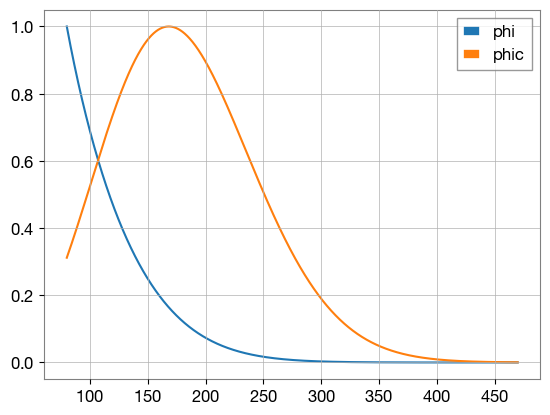

In [21]:
sigma = np.linspace(80, 470, 10000)
from ler.lens_galaxy_population import phi

phi_ = phi(sigma, 0.5)
phi_c = phi(sigma, 0.5)*sigma**4

import matplotlib.pyplot as plt
plt.plot(sigma, phi_/np.max(phi_), label='phi')
plt.plot(sigma, phi_c/np.max(phi_c), label='phic')
plt.legend()
plt.show()

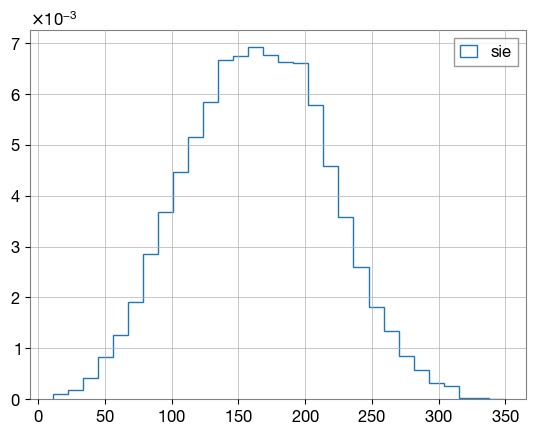

In [31]:
zl = lensed_param_sie['zl']
idx = zl < 1.5
plt.hist(lensed_param_sie['sigma'][idx], histtype='step', bins=30, density=True, label='sie')
plt.legend()
plt.show()

In [21]:
#sigma10000 = lensed_param['sigma']
# sigma1000 = lensed_param['sigma']
sigma50000 = lensed_param['sigma']

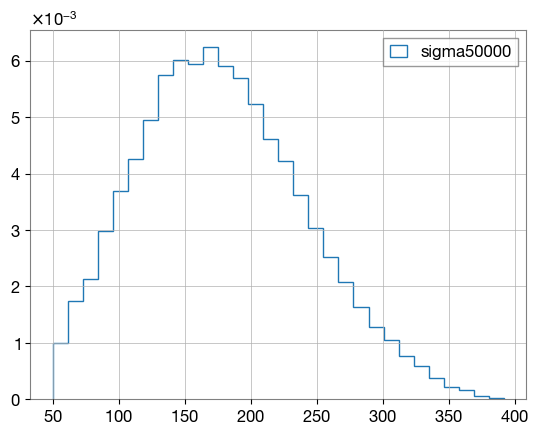

In [22]:
import matplotlib.pyplot as plt
# plt.hist(sigma1000, histtype='step', bins=30, density=True, label='sigma1000')
# plt.hist(sigma10000, histtype='step', bins=30, density=True, label='sigma10000')
plt.hist(sigma50000, histtype='step', bins=30, density=True, label='sigma50000')
plt.legend()
plt.show()

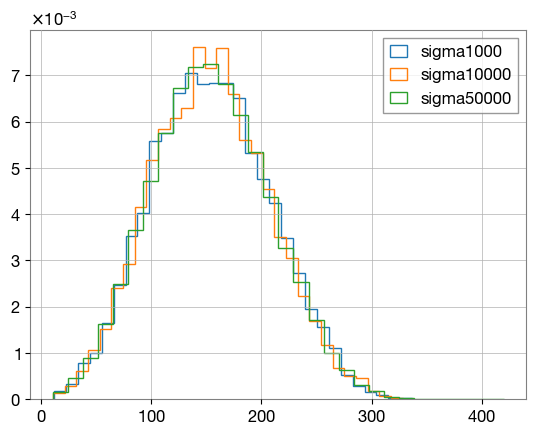

In [14]:
import matplotlib.pyplot as plt
plt.hist(sigma1000, histtype='step', bins=30, density=True, label='sigma1000')
plt.hist(sigma10000, histtype='step', bins=30, density=True, label='sigma10000')
plt.hist(sigma50000, histtype='step', bins=30, density=True, label='sigma50000')
plt.legend()
plt.show()

In [2]:
import numpy as np

q_args_cdf_values = ler.axis_ratio.cdf_values
q_args_x_array = ler.axis_ratio.x_array
q_args_conditioned_y_array = ler.axis_ratio.conditioned_y_array

sigma_args_cdf_values = ler.velocity_dispersion.cdf_values
sigma_args_x_array = ler.velocity_dispersion.x_array
sigma_args_conditioned_y_array = ler.velocity_dispersion.conditioned_y_array

da_args_function_spline = ler.angular_diameter_distance.function_spline
da_args_x_array = ler.angular_diameter_distance.x_array

In [3]:
ler.angular_diameter_distance.function_spline.shape, ler.angular_diameter_distance.x_array.shape

((4, 499), (500,))

In [4]:
size = 50000
buffer_size = 1000
zs = ler.sample_source_redshift_sl(size)
# # Sample lens redshifts
zl = ler.lens_redshift.rvs(size, zs)

In [13]:
sigma, theta_E, q = rjs_sie_mp_njit(zs, zl, sigma_args_cdf_values, sigma_args_x_array, sigma_args_conditioned_y_array, q_args_cdf_values, q_args_x_array, q_args_conditioned_y_array, da_args_function_spline, da_args_x_array, buffer_size)
# size = 50000, buffer_size = 2000: 1m 24s
# size = 10000, buffer_size = 2000: 17s
# size = 50000, buffer_size = 1000: 45s

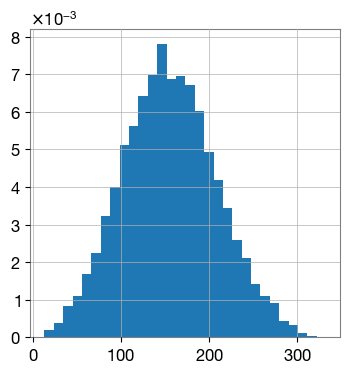

In [28]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4))
plt.hist(sigma,bins=30,density=True)
plt.show()

In [17]:
# multiprocessing test
import numpy as np

q_args_cdf_values = ler.axis_ratio.cdf_values
q_args_x_array = ler.axis_ratio.x_array
q_args_conditioned_y_array = ler.axis_ratio.conditioned_y_array

sigma_args_cdf_values = ler.velocity_dispersion.cdf_values
sigma_args_x_array = ler.velocity_dispersion.x_array
sigma_args_conditioned_y_array = ler.velocity_dispersion.conditioned_y_array

da_args_function_spline = ler.angular_diameter_distance.function_spline
da_args_x_array = ler.angular_diameter_distance.x_array

size = 10000
buffer_size = 1000
zs = ler.sample_source_redshift_sl(size)
# # Sample lens redshifts
zl = ler.lens_redshift.rvs(size, zs)
idx = np.arange(size)

sigma = np.zeros(size)
theta_E = np.zeros(size)
q =  np.zeros(size)

input_params = np.array([(idx[i], zs[i], zl[i], sigma_args_cdf_values, sigma_args_x_array, sigma_args_conditioned_y_array, q_args_cdf_values, q_args_x_array, q_args_conditioned_y_array, da_args_function_spline, da_args_x_array, buffer_size) for i in range(size)], dtype=object)

from multiprocessing import Pool
from tqdm import tqdm

with Pool(processes=ler.npool) as pool:
    for result in tqdm(
        pool.imap_unordered(rjs_sie_mp, input_params),
        total=size,
        ncols=100,
        disable=False,
    ):
        # print(result)
        (
            idx_,
            sigma_,
            theta_E_,
            q_,
        ) = result

        sigma[idx_] = sigma_
        theta_E[idx_] = theta_E_
        q[idx_] = q_
# with for loop only
for i in tqdm(range(size)):
    (
        idx_,
        sigma_,
        theta_E_,
        q_,
    ) = rjs_sie_mp(input_params[i])
    sigma[idx_] = sigma_
    theta_E[idx_] = theta_E_
    q[idx_] = q_


# mp: 1000,1000: 1m 54s
# mp: 1000,1000: 1m 26s


100%|██████████| 10000/10000 [00:09<00:00, 1062.22it/s]


In [13]:
from ler.utils import inverse_transform_sampler, inverse_transform_sampler2d, cubic_spline_interpolator
from ler.lens_galaxy_population import phi_cut_SIE

def rjs_sie_mp(args):

    idx, zs, zl, sigma_args_cdf_values, sigma_args_x_array, sigma_args_conditioned_y_array, q_args_cdf_values, q_args_x_array, q_args_conditioned_y_array, da_args_function_spline, da_args_x_array, buffer_size = args

    zl_ = zl*np.ones(buffer_size) # need for sigma computation
    while True:
        # velocity dispersion distribution
        if sigma_args_conditioned_y_array is not None:
            sigma = inverse_transform_sampler2d(buffer_size, zl_, sigma_args_cdf_values, sigma_args_x_array, sigma_args_conditioned_y_array)
        else:
            sigma = inverse_transform_sampler(buffer_size, zl_, sigma_args_cdf_values, sigma_args_x_array)

        # axis ratio distribution
        if q_args_conditioned_y_array is not None:
            q = inverse_transform_sampler2d(buffer_size, sigma, q_args_cdf_values, q_args_x_array, q_args_conditioned_y_array)
        else:
            q = inverse_transform_sampler(buffer_size, sigma, q_args_cdf_values, q_args_x_array)
    
        ## Einstein radius calculation
        # angular diameter distance
        Da_zs = cubic_spline_interpolator(np.array([zs]), da_args_function_spline, da_args_x_array)[0] # float
        Da_zl = cubic_spline_interpolator(np.array([zl]), da_args_function_spline, da_args_x_array)[0]

        # einstein radius 
        Dls = (Da_zs*(1+zs) - Da_zl*(1+zl))/(1+zs)
        theta_E = (
            4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / Da_zs
        )  # Note: km/s for sigma; Dls, Ds are in Mpc

        # cross-section
        cross_section = phi_cut_SIE(q) * np.pi*theta_E**2

        # rejection sampling
        max_ = np.max(cross_section)  # maximum einstein radius
        u = np.random.uniform(0, max_, size=buffer_size)
        mask = u < cross_section
        if np.sum(mask) > 0:
            break

    sigma_final = sigma[mask][0]
    theta_E_final = theta_E[mask][0]
    q_final = q[mask][0]
    # print(idx)

    return(idx, sigma_final, theta_E_final, q_final)

In [16]:
from ler.utils import inverse_transform_sampler2d, cubic_spline_interpolator
from ler.lens_galaxy_population import phi_cut_SIE
from numba import njit, jit

def rjs_sie_mp_njit(zs, zl, sigma_args_cdf_values, sigma_args_x_array, sigma_args_conditioned_y_array, q_args_cdf_values, q_args_x_array, q_args_conditioned_y_array, da_args_function_spline, da_args_x_array, buffer_size):

    size = len(zs)
    sigma_final = np.zeros(size)
    theta_E_final = np.zeros(size)
    q_final = np.zeros(size)
    
    for i in range(size):
        zs_ = zs[i]*np.ones(buffer_size)
        zl_ = zl[i]*np.ones(buffer_size)
        while True:
            # velocity dispersion distribution
            sigma = inverse_transform_sampler2d(buffer_size, zl_, sigma_args_cdf_values, sigma_args_x_array, sigma_args_conditioned_y_array)

            # axis ratio distribution
            q = inverse_transform_sampler2d(buffer_size, sigma, q_args_cdf_values, q_args_x_array, q_args_conditioned_y_array)
        
            ## Einstein radius calculation
            # angular diameter distance
            Da_zs = cubic_spline_interpolator(np.array([zs[i]]), da_args_function_spline, da_args_x_array)[0] # float
            Da_zl = cubic_spline_interpolator(np.array([zl[i]]), da_args_function_spline, da_args_x_array)[0]

            # einstein radius 
            Dls = (Da_zs*(1+zs[i]) - Da_zl*(1+zl[i]))/(1+zs[i])
            theta_E = (
                4.0 * np.pi * (sigma / 299792.458) ** 2 * Dls / Da_zs
            )  # Note: km/s for sigma; Dls, Ds are in Mpc

            # cross-section
            cross_section = phi_cut_SIE(q) * np.pi*theta_E**2

            # rejection sampling
            max_ = np.max(cross_section)  # maximum einstein radius
            u = np.random.uniform(0, max_, size=buffer_size)
            mask = u < cross_section
            if np.sum(mask) > 0:
                break

        sigma_final[i] = sigma[mask][0]
        theta_E_final[i] = theta_E[mask][0]
        q_final[i] = q[mask][0]

    return(sigma_final, theta_E_final, q_final)

In [17]:
sigma, theta_E, q = rjs_sie_mp_njit(zs, zl, sigma_args_cdf_values, sigma_args_x_array, sigma_args_conditioned_y_array, q_args_cdf_values, q_args_x_array, q_args_conditioned_y_array, da_args_function_spline, da_args_x_array, buffer_size)

In [5]:
ler.rejection_sample_sl = ler.rjs_with_cross_section_mp
lensed_param = ler.sample_all_routine_epl_shear_sl(500)

100%|██████████| 500/500 [01:03<00:00,  7.91it/s]


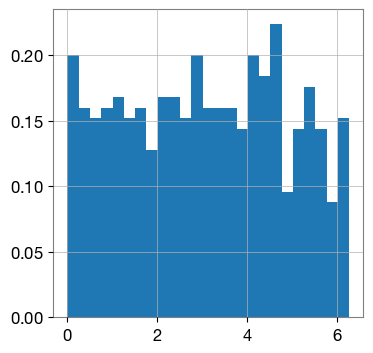

In [15]:
from matplotlib import pyplot as plt
plt.figure(figsize=(4,4))
sigma = lensed_param['phi']
plt.hist(sigma,bins=25,density=True)
plt.show()

/var/folders/ws/0948zvwd7g795j2l3fryghjw0000gp/T/ipykernel_27748/3894370692.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sample2[i] = np.random.normal(0, 1, 1)


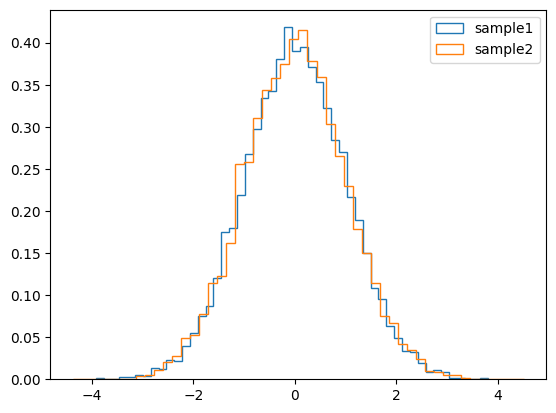

In [2]:
import numpy as np
import matplotlib.pyplot as plt

sample1 = np.random.normal(0, 1, 10000)
sample2 = np.zeros(10000)
for i in range(10000):
    sample2[i] = np.random.normal(0, 1, 1)

plt.hist(sample1, bins=50, density=True, histtype='step', label='sample1')
plt.hist(sample2, bins=50, density=True, histtype='step', label='sample2')
plt.legend()
plt.show()